In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# DATA PREPARATION

Now when you call fetch_housing_data(), it creates a datasets/housing directory in your workspace, downloads the housing.tgz file, and extracts the housing.csv from it in this directory. 

In [ ]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import pandas as pd
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

Now let’s load the data using Pandas. Once again you should write a small function to load the data:

In [ ]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing=load_housing_data()
housing.info()

In [ ]:
housing.head()

In [ ]:
housing.describe()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20,15)) 
plt.show()

For example, you can see that slightly over 800 districts have a median_house_value equal to about $100,000.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

# TEST SET PREPARATION

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):


Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:


## PURELY RANDOM SAMPLING METHOD

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) 

## STRATIFIED SAMPLING

the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population

For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased. 

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

In [ ]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)  
housing["income_cat"].hist()


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):    
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

In [ ]:
 strat_test_set["income_cat"].value_counts() / len(strat_test_set)

Making comparisons with original dataset
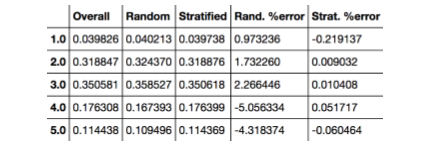

Now you should remove the income_cat attribute so the data is back to its original state:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) 

In [ ]:
#copying the training set
housing=strat_train_set.copy()

# VISUALIZING DATA

In [ ]:
housing.plot(kind="scatter",x="longitude",y="latitude")

POPULATION DENSITY

In [ ]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

POPULATION DENSITY & PRICE TOGATHER

The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, ) 
plt.legend()


This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule. 

### CORRELATION DETECTION

###### Method 1

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method:

In [ ]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). Note how all the plots of the bottom row have a correlation coefficient equal to zero despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.

###### Method 2

Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page, so let’s just focus on a few promising attributes that seem most correlated with the median housing value

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"] 
scatter_matrix(housing[attributes], figsize=(12, 8))

There is strong correlation between median_house_value and median_income

#### Attribute combinations

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [ ]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are. 

But first let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):


In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

# DATA CLEANING

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this.

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:


###### For numerical attributes

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)


The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.

In [ ]:
imputer.statistics_

In [ ]:
housing_num.median().values

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [ ]:
X=imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

###### For text & categorical attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median:


In [ ]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head(10)

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder 

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) 
housing_cat_encoded[:10]

To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [ ]:
from sklearn.preprocessing import OneHotEncoder 

cat_encoder=OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. 

In [ ]:
housing_cat_1hot.toarray()
cat_encoder.categories_

##### *NOTE

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species, etc.), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable low dimensional vector called an embedding. Each category’s representation would be learned during training: this is called representation learning (see Chapter 15 for more details). 

##### CUSTOM TRANSFORMERS USING SCIKIT LEARN

you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines)

All you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstima tor as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) 

## DATA SCALING

Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

###### min-max scalling (normalization)

values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason. 

###### Standardization

first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). Scikit-Learn provides a transformer called StandardScaler for standardization.


###### However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected

### USING PIPELINES

Here is a small pipeline for the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with Pandas DataFrames. Let’s use it to apply all the transformations to the housing data:

In [ ]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])
housing_prepared = full_pipeline.fit_transform(housing) 

# SELECT & TRAIN MODEL

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

 Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function:

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions) 
lin_rmse = np.sqrt(lin_mse)
round(lin_rmse,1) 

most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data

In [ ]:
from sklearn.externals import joblib
joblib.dump(lin_reg, "linreg_cali_housing.pkl") 

In [ ]:
#lin_reg_loaded=joblib.load("linreg_cali_housing.pkl")

## Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels) 

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions) 
tree_rmse = np.sqrt(tree_mse)
round(tree_rmse,1) 

 Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation. 

##### CROSS-VALIDATION

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root

In [ ]:
def display_scores(scores): 
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [ ]:
from sklearn.externals import joblib
lin_reg_loaded=joblib.load("linreg_cali_housing.pkl")

lin_scores = cross_val_score(lin_reg_loaded, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10) 
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

###### That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [ ]:
from sklearn.externals import joblib
joblib.dump(tree_reg, "treereg_cali_housing.pkl")

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg=RandomForestRegressor()
rf_reg.fit(housing_prepared,housing_labels)

In [ ]:
from sklearn.model_selection import cross_val_score 
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

It looks promising

In [ ]:
from sklearn.externals import joblib
joblib.dump(rf_reg, "rf_cali_housing.pkl")

## Support Vector Machine Regressor

###### RBF kernel

In [ ]:
from sklearn.svm import SVR

svr_rbf_reg=SVR(kernel='rbf',gamma='auto')
svr_rbf_reg.fit(housing_prepared,housing_labels)

In [ ]:
from sklearn.model_selection import cross_val_score 
svr_rbf_scores = cross_val_score(svr_rbf_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

svr_rbf_rmse_scores = np.sqrt(-svr_rbf_scores)
display_scores(svr_rbf_rmse_scores)

This is very bad

###### Linear kernel

In [ ]:
from sklearn.svm import SVR

svr_lin_reg=SVR(kernel='linear',gamma='auto')
svr_lin_reg.fit(housing_prepared,housing_labels)

In [ ]:
from sklearn.model_selection import cross_val_score 
svr_lin_scores = cross_val_score(svr_lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

svr_lin_rmse_scores = np.sqrt(-svr_lin_scores)
display_scores(svr_lin_rmse_scores)

This is better than RBF but worse than previous models

###### Polynomial Kernel

In [ ]:
from sklearn.svm import SVR

svr_poly_reg=SVR(kernel='poly',gamma='auto',degree=6)
svr_poly_reg.fit(housing_prepared,housing_labels)

In [ ]:
from sklearn.model_selection import cross_val_score 
svr_poly_scores = cross_val_score(svr_poly_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

svr_poly_rmse_scores = np.sqrt(-svr_poly_scores)
display_scores(svr_poly_rmse_scores)

Standard deviation is very bad

Let us save linear kernel for future

In [ ]:
from sklearn.externals import joblib
joblib.dump(svr_lin_reg, "svr_lin_cali_housing.pkl")

## Nearest Neighbour Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg=KNeighborsRegressor()
knn_reg.fit(housing_prepared,housing_labels)

In [ ]:
from sklearn.model_selection import cross_val_score 
knn_scores = cross_val_score(knn_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

knn_rmse_scores = np.sqrt(-knn_scores)
display_scores(knn_rmse_scores)

This is acceptable

In [ ]:
from sklearn.externals import joblib
joblib.dump(knn_reg, "knn_cali_housing.pkl")

## Neural Network

from sklearn.neural_network import MLPRegressor
mlp_reg=MLPRegressor(max_iter=1000,random_state=3)
mlp_reg.fit(housing_prepared,housing_labels)

from sklearn.model_selection import cross_val_score 
mlp_scores = cross_val_score(mlp_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

mlp_rmse_scores = np.sqrt(-mlp_scores)
display_scores(mlp_rmse_scores)

# Tuning models

## Random Forest

In [ ]:
from sklearn.externals import joblib
forest_reg=joblib.load("rf_cali_housing.pkl")

##### Grid Search Method

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

RMSE score is 49412 where as for default model it is 52701. Hence the tuning is complete.

##### Randomized Search Method

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.  If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

#forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
rnd_search.best_params_

The Randomized search has given little better result than Grid search. This is the best we can get from Random Forest

## Nearest Neighbor model

In [ ]:
from sklearn.externals import joblib
knn_reg=joblib.load("knn_cali_housing.pkl")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_neighbors': randint(low=1, high=20),
        'leaf_size': randint(low=1, high=50),
    }


rnd_search = RandomizedSearchCV(knn_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
rnd_search.best_params_

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

The score has improved a little. But Random Foest is the best model.

# EVALUATE ON TEST SET

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1) 
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions) 
final_rmse = np.sqrt(final_mse)   # => evaluates to 47,376.1 

In [ ]:
print(round(final_rmse,1))

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

In [ ]:
from scipy import stats
confidence=0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(), 
                         scale=stats.sem(squared_errors))) 


The performance will usually be slightly worse than what you measured using crossvalidation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data. 

Finally, you will generally want to train your models on a regular basis using fresh data. You should automate this process as much as possible. If you don’t, you are very likely to refresh your model only every six months (at best), and your system’s performance may fluctuate severely over time. If your system is an online learning system, you should make sure you save snapshots of its state at regular intervals so you can easily roll back to a previously working state.
